In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from scipy.interpolate import griddata
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import itertools
import salem
import scipy.spatial.qhull as qhull

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
import xesmf as xe

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

Read the different file types: pb-tags indicate pressure level files, pc-tags indicate pure surface files.
Past is 1980 vegetation, current is 2010. 
Topography and vegetation information is saved in ancillaries folder 'ancils'.

In [2]:
VERA_data_dir = '/home/ck/DIR/cornkle/data/vera_out/'

pl_files_current = glob.glob(VERA_data_dir+'current*pb*.nc')
pl_files_past = glob.glob(VERA_data_dir+'past*pb*.nc')
surface_files_current = glob.glob(VERA_data_dir+'current*pc*.nc')
surface_files_past = glob.glob(VERA_data_dir+'past*pc*.nc')
ancil_path = VERA_data_dir + 'ancils/'

In [3]:
# Interpolation utilities. Interpolation_weights calculates the weighting for triangulisation between
# two coordinate systems. Interpolate_data finally interpolates the data.


def _interp_weights(xyz, uvw, d=None):

    """
    :param xyz: flattened coords of current grid
    :param uvw: flattened coords of target grid
    :param d: number of dimensions of new grid
    :return: triangulisation lookup table, point weights
    """
    tri = qhull.Delaunay(xyz)
    simplex = tri.find_simplex(uvw)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uvw - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def _interpolate(values, vtx, wts, fill_value=np.nan):

    """
    :param values: flattened data values
    :param vtx: lookup table
    :param wts: point weights
    :param fill_value: fill value for extrapolated regions
    :return: interpolated data
    """
    ret = np.einsum('nj,nj->n', np.take(values, vtx), wts)
    ret[np.any(wts < 0, axis=1)] = fill_value
    return ret

def interpolation_weights(x, y, new_x, new_y):

    """
    :param x: current x variables (1 or 2d, definitely 2d if irregular!)
    :param y: current y variables (1 or 2d, definitely 2d if irregular!)
    :param new_x: target x vars
    :param new_y: target y vars
    :return:  triangulisation lookup table, point weights, 2d shape - inputs for interpolation func
    """

    if x.ndim == 1:
        grid_xs, grid_ys = np.meshgrid(x, y)
    else:
        grid_xs = x
        grid_ys = y

    if new_x.ndim == 1:
        new_xs, new_ys = np.meshgrid(new_x, new_y)
    else:
        new_xs = new_x
        new_ys = new_y

    points = np.array((grid_xs.flatten(), grid_ys.flatten())).T
    inter = np.array((np.ravel(new_xs), np.ravel(new_ys))).T

    inds, weights = _interp_weights(points, inter, d=2)

    return inds, weights, new_xs.shape


def interpolate_data(data, inds, weights, shape):

    """
    This routine interpolates only over the 2d plane i.e. spatial interpolation
    :param data: original data, 2d, 3d or 4d (e.g. incl. time steps and pressure levels).

    :param inds: lookup table from weights func
    :param weights: index weights from weights func
    :param shape: 2d shape of plane
    :return: interpolated data, same number of dimensions as input data
    """

    if (data.ndim < 2) | (data.ndim > 4):
        print('Error. Only data with 2 - 4 dimensions allowed.')
        return
    # interpolate 2d arrays
    coll = []
    if data.ndim > 2:
        for d in data:
            if d.ndim == 2:

                d2d = _interpolate(d.flatten(), inds, weights)
                d2d = d2d.reshape(shape)
                coll.append(d2d[None, ...])

            if d.ndim == 3:
                plevs = []

                for pl in d:
                    
                    pl2d = _interpolate(pl.flatten(), inds, weights)
                    pl2d = pl2d.reshape(shape)
                    plevs.append(pl2d[None, ...])
                if len(plevs) > 1:
                    plevs = np.concatenate(plevs, axis=0)
                coll.append(plevs[None, ...])
        if len(coll) > 1:
            coll = np.concatenate(coll, axis=0)
    else:
        d2d = _interpolate(data.flatten(), inds, weights)
        d2d = d2d.reshape(shape)
        coll = d2d

    return coll

In [4]:
def u_v_to_ws_wd(u,v):
    """
    This function computes wind speed and wind direction from given u,v wind components
    Wind direction indicates where the wind is coming from. 
    :param u:
    :param v:
    :return: tuple (wind speed, wind direction (convention "wind coming from")
    """

    ws = np.array(np.sqrt(u*u + v*v))
    wd = np.array(180. + np.arctan2(u, v) * 180./ np.pi)  # dir where wind is coming from
    pos = np.where(ws == 0)
    try:
        wd[pos] = np.nan
    except IndexError:
        pass

    return ws,wd

In [5]:
srfc_cur = xr.open_mfdataset(surface_files_current)
srfc_past = xr.open_mfdataset(surface_files_past)
pl_cur = xr.open_mfdataset(pl_files_current)
pl_past = xr.open_mfdataset(pl_files_past)

In [6]:
# decode_times=False is needed because the ancils have no real time step and without it
# xarray would try to read the time, fail, and then give an error. With the keyword however you can read it. 

all_ancil =xr.open_dataset(ancil_path + 'ancils_vera.nc', decode_times=False) 

In [7]:
pl_cur

<xarray.Dataset>
Dimensions:                     (false_latitude: 380, false_longitude: 750, pressure_levels: 16, time: 480)
Coordinates:
  * false_latitude              (false_latitude) float64 -8.28 -8.244 ... 5.364
  * false_longitude             (false_longitude) float64 -14.6 -14.56 ... 12.36
    true_latitude               (false_latitude, false_longitude) float64 0.9178 ... 14.64
    true_longitude              (false_latitude, false_longitude) float64 -16.95 ... 10.23
  * pressure_levels             (pressure_levels) float64 975.0 950.0 ... 200.0
  * time                        (time) datetime64[ns] 2014-04-05T01:00:00 ... 2014-04-06
Data variables:
    lst                         (time, false_latitude, false_longitude) float32 dask.array<shape=(480, 380, 750), chunksize=(24, 380, 750)>
    q2                          (time, false_latitude, false_longitude) float32 dask.array<shape=(480, 380, 750), chunksize=(24, 380, 750)>
    T2                          (time, false_latitude,

In [8]:
ucur = pl_cur['u10']   # data for wind example
vcur = pl_cur['v10']

upast = pl_past['u10']   # data for wind example
vpast = pl_past['v10']

In [9]:
rain = srfc_cur['TotalRain'] # NOTE: RAINFALL IS PER SECOND, NOT PER HOUR. HAS TO BE MULTIPLIED BY 3600 for mm/h
np.unique(rain['time.day'])

array([ 5,  6,  7,  8,  9, 10])

In [10]:
srfc_cur.TotalRain.values.max()*3600  ## rainfall check - looks fine.

87.02717497944832

(array([1449536.,  529016.,  280776.,  181823.,  124791.,   82595.,
          53909.,   36147.,   23838.,   15509.]),
 array([ 1,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
 <a list of 10 Patch objects>)

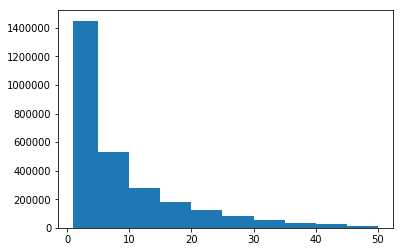

In [11]:
plt.hist((srfc_cur.TotalRain.values.flatten())*3600, bins=[1,5,10,15,20,25,30,35,40,45,50]) # rainfall disribution

In [12]:
# In this step we read a variable and wind components for later plotting. Both variables are grouped by
# hours and averaged over all available 6 days.

cur = srfc_cur['TotalRain'].groupby('time.hour').mean('time')*3600   ### input variable for plotting below
past = srfc_past['TotalRain'].groupby('time.hour').mean('time')*3600

ucur = ucur.groupby('time.hour').mean('time')  ## wind for plotting below
vcur = vcur.groupby('time.hour').mean('time')

upast = upast.groupby('time.hour').mean('time')  ## wind for plotting below
vpast = vpast.groupby('time.hour').mean('time')

In [13]:
cur.values.min()

-1.3722105e-17

In [14]:
# calculate wind speed and direction from u/v 
wscur, wdircur = u_v_to_ws_wd(ucur,vcur)

uano = ucur-upast
vano = vcur-vpast  # wind changes

In [15]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list [lon,lat,u,v,scale]
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
        
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

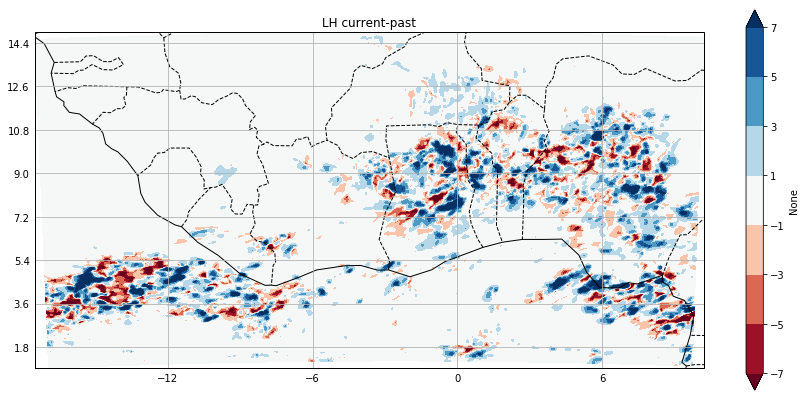

In [16]:
lon=srfc_cur.true_longitude
lat=srfc_cur.true_latitude
data=(cur-past).sel(hour=slice(0,6)).sum('hour')  # difference in average afternoon rainfall (mm / afternoon)
data2=all_ancil['veg_current']-all_ancil['veg_past']
title='LH diff'

draw_map(data, lon, lat, title='LH current-past', levels=np.linspace(-7,7,8), extend='both', cmap='RdBu')
## Note that rainfall differences are very noisy.

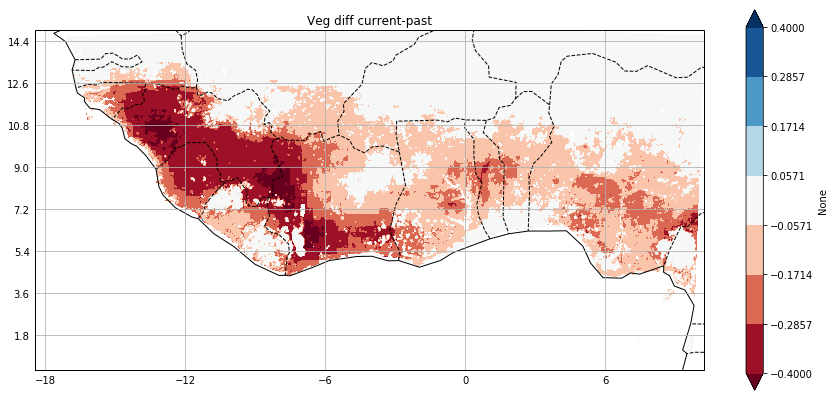

In [17]:
draw_map(data2, lon, lat, title='Veg diff current-past', levels=np.linspace(-0.4,0.4,8), extend='both', cmap='RdBu')

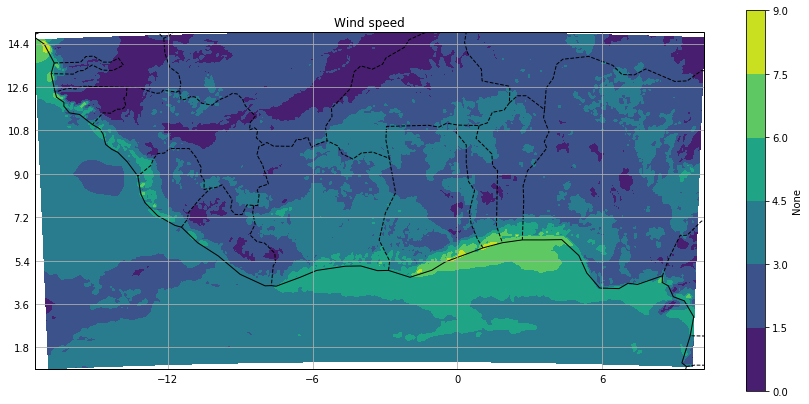

In [18]:
draw_map(wscur[15,:,:],lon,lat, title='Wind speed')

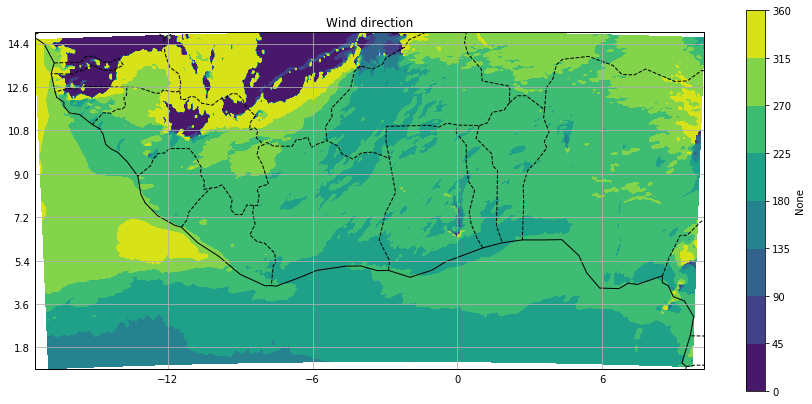

In [19]:
draw_map(wdircur[15,:,:],lon,lat, title='Wind direction', levels=np.arange(0,361,45))

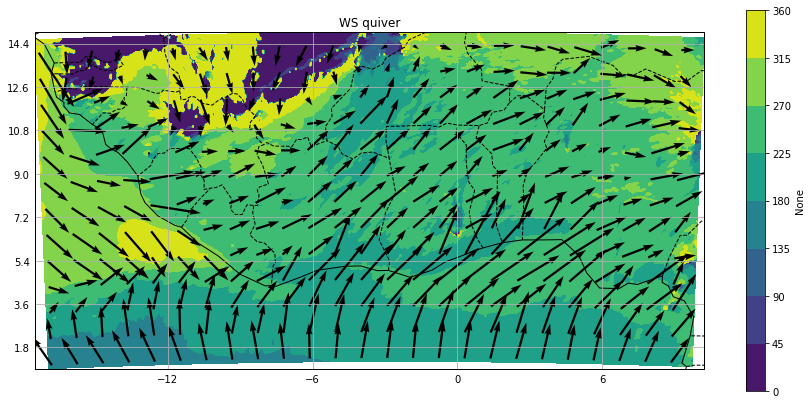

In [20]:
# preparation of wind vector data in plot
st=30
sarrow = 4
xquiv = ucur.true_longitude[sarrow::st, sarrow::st]
yquiv = ucur.true_latitude[sarrow::st, sarrow::st]

uu = (ucur[15,:,:])[sarrow::st, sarrow::st]
vv = (vcur[15,:,:])[sarrow::st, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 70}


draw_map(wdircur[15,:,:], lon, lat, title='WS quiver', quiver=qin,levels=np.arange(0,361,45))

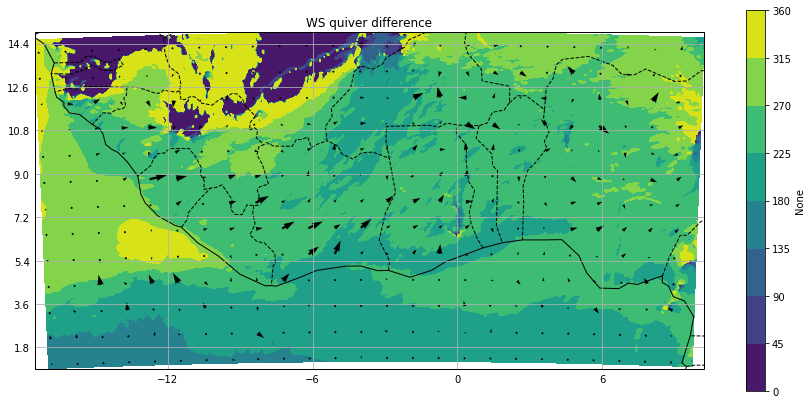

In [21]:
# differences in wind vectors
st=30
sarrow = 4
xquiv = ucur.true_longitude[sarrow::st, sarrow::st]
yquiv = ucur.true_latitude[sarrow::st, sarrow::st]

uu = (uano[15,:,:])[sarrow::st, sarrow::st]  # wind differences
vv = (vano[15,:,:])[sarrow::st, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 60}


draw_map(wdircur[15,:,:], lon, lat, title='WS quiver difference', quiver=qin,levels=np.arange(0,361,45))

In [22]:
# Grouping runs of current and past to do individual aggregation

current_runs = ['xmhkga', 'xmhkka', 'xmhkma', 'xmhkoa']
past_runs = ['xmhkja', 'xmhkla', 'xmhkna', 'xmhkpa']

In [23]:
diff_da = None
var = 'SH'
if var == 'TotalRain':
    c=3600
else:
    c=1
    
def collect(container, data, dim_name):
    if container is not None:
        container = xr.concat([container,data], dim_name)
    else:
        container = data
    
    return container


for cur, pas in itertools.product(current_runs, past_runs):
    surface_files_current = glob.glob(VERA_data_dir+'current_'+cur+'.pc*.nc')
    surface_files_past = glob.glob(VERA_data_dir+'past_'+pas+'.pc*.nc')
    
    srfc_cur = xr.open_mfdataset(surface_files_current)
    srfc_past = xr.open_mfdataset(surface_files_past)
    
    cur = srfc_cur[var].groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')
    past = srfc_past[var].groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')
        
    diffs = cur*c-past*c
    diff_da = collect(diff_da, diffs, 'cur-past')

arstack_cur = None
arstack_past = None    

for cur, pas in zip(current_runs, past_runs):
    surface_files_current = glob.glob(VERA_data_dir+'current_'+cur+'.pc*.nc')
    surface_files_past = glob.glob(VERA_data_dir+'past_'+pas+'.pc*.nc')
    
    srfc_cur = xr.open_mfdataset(surface_files_current)
    srfc_past = xr.open_mfdataset(surface_files_past)
    
    cur = srfc_cur[var].groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')
    past = srfc_past[var].groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')
#     cur = (srfc_cur['SH'])[srfc_cur['time.hour'] == 15]
#     past = (srfc_past['SH'])[srfc_past['time.hour'] == 15]

    arstack_cur = collect(arstack_cur, cur*c, 'cur') ## individual ensemble members are stacked in one array for subsequent t-test per pixel.
    arstack_past = collect(arstack_past, past*c, 'past')


In [24]:
tstat, pval = stats.ttest_ind(arstack_cur, arstack_past, axis=0) ## t-test for equal means of past and current ensemble (based on a sample size of 4..not great!)
amask = (pval<=0.01).astype(int)  # test pvalue significance level at 0.01

/home/ck/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


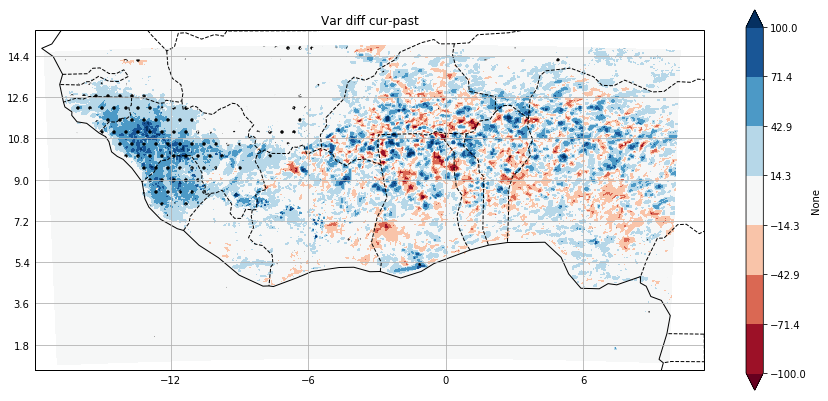

In [25]:
## plot with dots indicating significant changes based on t-test
draw_map(diff_da.mean('cur-past'), diff_da.true_longitude, diff_da.true_latitude, title='Var diff cur-past', levels=np.linspace(-100,100,8), extend='both', cmap='RdBu', mask_sig=amask)

In [26]:
# manually create coarser grid for regular-grid interpolation
new_lon = np.arange(-17,10.1,0.25)
new_lat = np.arange(1,14.1,0.25)

X, Y = np.meshgrid(new_lon, new_lat)
X.shape

(53, 109)

In [27]:
new_grid = xr.Dataset({'lat': (['y', 'x'], Y),
                     'lon': (['y', 'x'], X)}, coords={'x' : np.arange(X.shape[1]), 'y' : np.arange(X.shape[0])})

In [28]:
test = pl_cur.groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')
test = test.rename({'true_latitude':'lat', 'true_longitude' : 'lon'})

In [29]:
regridder = xe.Regridder(test, new_grid, 'bilinear')
regridder  # print basic regridder information.

Overwrite existing file: bilinear_380x750_53x109.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_380x750_53x109.nc 
Reuse pre-computed weights? False 
Input grid shape:           (380, 750) 
Output grid shape:          (53, 109) 
Output grid dimension name: ('y', 'x') 
Periodic in longitude?      False

In [30]:
new_grid

<xarray.Dataset>
Dimensions:  (x: 109, y: 53)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 100 101 102 103 104 105 106 107 108
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 43 44 45 46 47 48 49 50 51 52
Data variables:
    lat      (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 14.0 14.0 14.0 14.0 14.0
    lon      (y, x) float64 -17.0 -16.75 -16.5 -16.25 ... 9.25 9.5 9.75 10.0

In [31]:
## we'll now interpolate on regular grids to plot cross-sections of variables

# In this step we read a variable and wind components for later plotting. Both datasets are grouped by
# hours and averaged over all available 6 days.

cur = pl_cur.groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')   ### input variable for plotting below
past = pl_past.groupby('time.hour').mean('time').sel(hour=slice(12,16)).mean('hour')

In [32]:
# based on the new and old lat/lon grids, this calculates weights for every data pixel in the new grid
# since the grids are always identical and the step is computationally expensive, it's only done once - not in the loop!
inds, weights, shape = interpolation_weights(cur.true_longitude.values, cur.true_latitude.values, new_lon, new_lat)

In [33]:
## Regridding data, this takes a while since it loops through all variables and pressure levels
varlist = ['T_pl', 'u_pl', 'v_pl', 'q_pl', 'w_pl']

In [34]:
cur_ds_new = xr.Dataset()
for key in cur:
    if key not in varlist:
        continue
    print('Doing '+key)

    darray = cur[key] 
    regridded = regridder(darray)
    
    new_da = xr.DataArray(regridded, coords=[darray.pressure_levels,new_lat, new_lon], dims=['p_lev', 'lat', 'lon'])
    new_da.attrs = darray.attrs
    cur_ds_new[key] = new_da

/home/ck/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  


Doing w_pl


/home/ck/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Doing u_pl
Doing v_pl
Doing T_pl
Doing q_pl


In [35]:
cur_ds = xr.Dataset()
for key in cur:
    if key not in varlist:
        continue
    print('Doing '+key)

    darray = cur[key] 
    regridded = interpolate_data(darray.values, inds, weights, shape)

    new_da = xr.DataArray(regridded, coords=[darray.pressure_levels,new_lat, new_lon], dims=['p_lev', 'lat', 'lon'])
    new_da.attrs = darray.attrs
    cur_ds[key] = new_da

/home/ck/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  


Doing w_pl


/home/ck/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Doing u_pl
Doing v_pl
Doing T_pl
Doing q_pl


In [36]:
past_ds = xr.Dataset()
for key in past:
    if key not in varlist:
        continue
    print('Doing '+key)

    darray = past[key] 
    regridded = interpolate_data(darray.values, inds, weights, shape)
    
    new_da = xr.DataArray(regridded, coords=[darray.pressure_levels,new_lat, new_lon], dims=['p_lev', 'lat', 'lon'])
    new_da.attrs = darray.attrs
    past_ds[key] = new_da

/home/ck/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  


Doing w_pl


/home/ck/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Doing u_pl
Doing v_pl
Doing T_pl
Doing q_pl


In [37]:
cur_ds_new

<xarray.Dataset>
Dimensions:  (lat: 53, lon: 109, p_lev: 16)
Coordinates:
  * p_lev    (p_lev) float64 975.0 950.0 925.0 900.0 ... 450.0 400.0 300.0 200.0
  * lat      (lat) float64 1.0 1.25 1.5 1.75 2.0 ... 13.0 13.25 13.5 13.75 14.0
  * lon      (lon) float64 -17.0 -16.75 -16.5 -16.25 ... 9.25 9.5 9.75 10.0
Data variables:
    w_pl     (p_lev, lat, lon) float64 0.0 -0.003991 ... -0.007455 -0.01167
    u_pl     (p_lev, lat, lon) float64 0.0 -2.433 -2.31 ... 19.06 19.12 19.18
    v_pl     (p_lev, lat, lon) float64 0.0 3.136 3.102 ... 7.001 7.394 7.758
    T_pl     (p_lev, lat, lon) float64 0.0 297.8 297.8 ... 218.7 218.7 218.7
    q_pl     (p_lev, lat, lon) float64 0.0 0.01748 ... 2.958e-05 3.069e-05

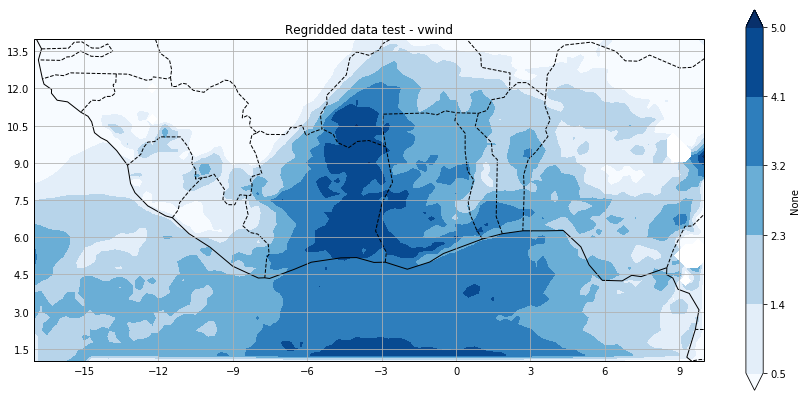

In [38]:
dat = cur_ds_new['v_pl']
draw_map(dat.sel(p_lev=900), new_lon, new_lat, title='Regridded data test - vwind', levels=np.linspace(0.5,5,6), extend='both', cmap='Blues')

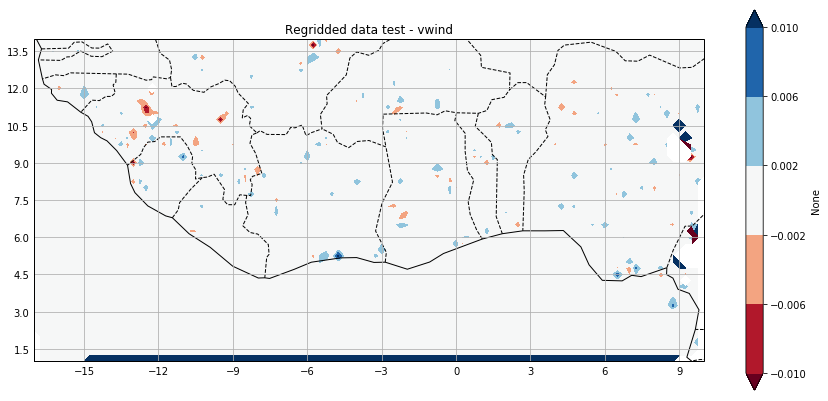

In [39]:
dat = cur_ds['T_pl']-cur_ds_new['T_pl']
draw_map(dat.sel(p_lev=900), new_lon, new_lat, title='Regridded data test - vwind', levels=np.linspace(-0.01,0.01,6), extend='both', cmap='RdBu')

In [40]:

vlist = ['veg_past', 'veg_current', 'topo']

In [41]:
ancil_ds = xr.Dataset()
for key in all_ancil:
    
    if key not in vlist:
        continue
    
    print('Doing '+key)

    darray = all_ancil[key] 
    regridded = interpolate_data(darray.values, inds, weights, shape)
    
    new_da = xr.DataArray(regridded, coords=[new_lat, new_lon], dims=['lat', 'lon'])
    new_da.attrs = darray.attrs
    ancil_ds[key] = new_da

Doing topo
Doing veg_past
Doing veg_current


/home/ck/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  


In [42]:
veg_diff = ancil_ds['veg_current']-ancil_ds['veg_past']
veg_diff.min()

<xarray.DataArray ()>
array(-0.516918)

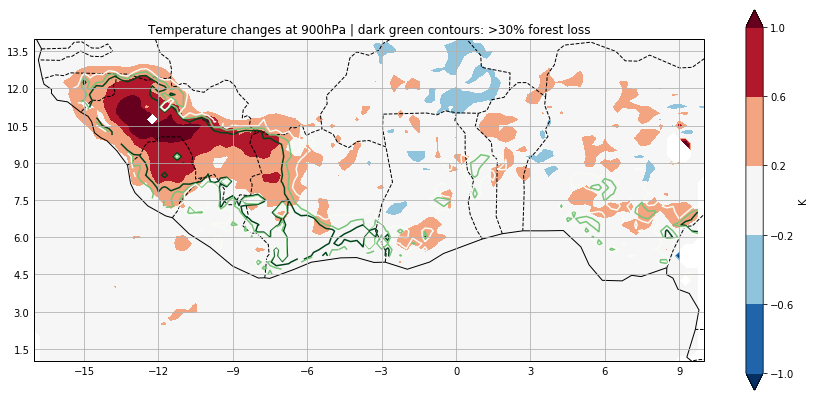

In [43]:
diff = cur_ds['T_pl']-past_ds['T_pl']

contour = {'data' : veg_diff*100, 'x' : veg_diff.lon, 'y' : veg_diff.lat, 'levels' : [-30, -25,-20], 'cmap' : 'Greens_r'}

draw_map(diff.sel(p_lev=900), diff.lon, diff.lat, title='Temperature changes at 900hPa | dark green contours: >30% forest loss', levels=np.linspace(-1,1,6), extend='both', cmap='RdBu_r', cbar_label="K", contour=contour)

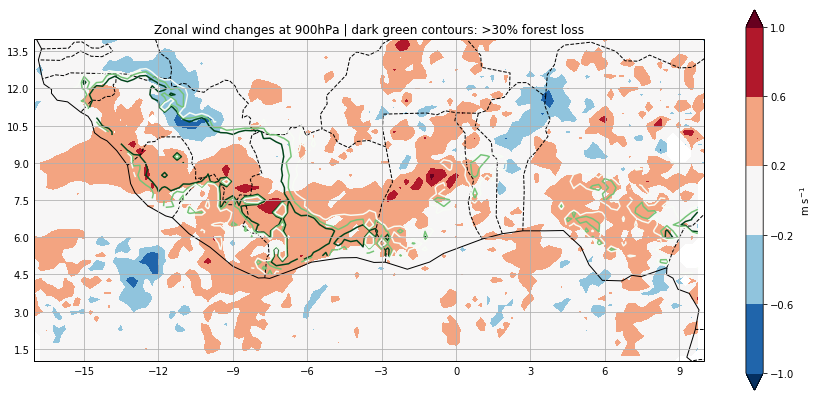

In [44]:
diff = cur_ds['u_pl']-past_ds['u_pl']
draw_map(diff.sel(p_lev=900), diff.lon, diff.lat, title='Zonal wind changes at 900hPa | dark green contours: >30% forest loss', levels=np.linspace(-1,1,6), extend='both', cmap='RdBu_r', cbar_label="m s$^{-1}$", contour=contour)

# Note the change in u wind around 9N, this might give us an incentive to look at temperature-related circulation changes in that region

In [45]:
### Cross-section pick